Populating the interactive namespace from numpy and matplotlib


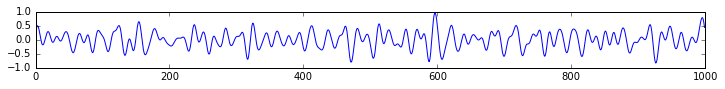

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from numba import jit
%pylab inline

def make_signal(nsamp):
    ref = np.random.rand(nsamp)
    wav = sig.ricker(80,5)
    filtered = np.convolve(ref, wav,'same')
    return filtered
    
res = make_signal(1000)
fig = plt.figure(figsize=(12,1))
plt.plot(res)


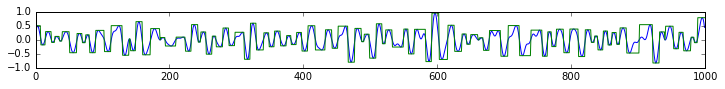

In [17]:

def response(inp, outp):
    tmp = np.asarray(np.where(inp<0)[0])
    inegs = np.split(tmp, np.where(np.diff(tmp) != 1)[0]+1)
    tmp = np.asarray(np.where(inp>0)[0])
    ipos = np.split(tmp, np.where(np.diff(tmp) != 1)[0]+1)
    for i in range(np.shape(inegs)[0]):
        outp[inegs[i]] = np.min(inp[inegs[i]])
    for i in range(np.shape(ipos)[0]):
        outp[ipos[i]] = np.max(inp[ipos[i]])
    
outp = np.zeros(res.shape)
response(res,outp)
fig = plt.figure(figsize=(12,1))
plt.plot(res)
plt.plot(outp)

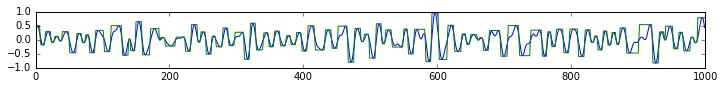

In [30]:
@jit(nopython=True)
def response_numba(inp, outp):
    ns = inp.shape[0]
    start = 0
    pos = inp[0]>0
    for i in range(ns):
        if inp[i]<0 and pos:
            if start<i-1:
                outp[start:i-1] = np.max(inp[start:i-1])
            else:
                outp[start] = inp[start]
            pos = False
            start = i
        if inp[i]>0 and not pos:
            if start<i-1:
                outp[start:i-1] = np.min(inp[start:i-1])
            else:
                outp[start] = inp[start]
            pos=True
            start = i
    if pos:
        if start<ns-1:
            outp[start:ns] = np.max(inp[start:ns])
        else:
            outp[start] = inp[start]
    else:
        if start<ns-1:
            outp[start:ns] = np.min(inp[start:ns])
        else:
            outp[start] = inp[start]
        
            
outp = np.zeros(res.shape)
response_numba(res,outp)
fig = plt.figure(figsize=(12,1))
plt.plot(res)
plt.plot(outp)         

In [29]:
%timeit -o response(res,outp)

1000 loops, best of 3: 757 µs per loop


<TimeitResult : 1000 loops, best of 3: 757 µs per loop>

In [31]:
%timeit -o response_numba(res,outp)

The slowest run took 4.11 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.93 µs per loop


<TimeitResult : 100000 loops, best of 3: 7.93 µs per loop>